# AIDev Pipeline de la PR au modèle de prédiction

Ce notebook illustre le pipeline complet suivant:

1. Chargement des données (.parquet) du dataset AIDev
2. Feature engineering (métriques PR, auteur, repo, collaboration)
3. Construction du dataset final (X, y)
4. Entraînement / chargement d’un modèle RandomForest
5. Évaluation globale (rapport de classification)
6. Interprétation par SHAP (importance globale + explications locales)


In [1]:

# Imports & chemins

from pathlib import Path
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import joblib
import shap
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Config des chemins (AIDev / data / artifacts / scripts)
# -------------------------------------------------------

BASE_DIR = Path.cwd()
if BASE_DIR.name == "notebooks":
    BASE_DIR = BASE_DIR.parent

DATA_ROOT = BASE_DIR / "data"
ARTIFACTS = BASE_DIR / "artifacts"

SCRIPTS_DIR = BASE_DIR / "scripts"
sys.path.append(str(SCRIPTS_DIR))

print("BASE_DIR :", BASE_DIR)
print("SCRIPTS_DIR :", SCRIPTS_DIR)
print("DATA_ROOT :", DATA_ROOT)
print("ARTIFACTS :", ARTIFACTS)

# -----------------------------
# Imports des modules du projet
# -----------------------------
from load_data import load_all
from feature_engineering import build_features
from merge_all import merge_with_user_repo

pd.set_option("display.max_colwidth", 120)


c:\Projets\AIDev\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BASE_DIR : c:\Projets\AIDev
SCRIPTS_DIR : c:\Projets\AIDev\scripts
DATA_ROOT : c:\Projets\AIDev\data
ARTIFACTS : c:\Projets\AIDev\artifacts


In [2]:
# Chargement des données brutes

dfs = load_all(DATA_ROOT)
{k: v.shape for k, v in dfs.items()}

{'pr': (33596, 14),
 'repo': (2807, 7),
 'user': (1796, 5),
 'pr_comments': (39122, 7),
 'pr_reviews': (28875, 7),
 'pr_review_comments_v2': (26868, 15),
 'pr_commits': (88576, 5),
 'pr_commit_details': (711923, 14),
 'related_issue': (4923, 3),
 'issue': (4614, 9),
 'pr_timeline': (325500, 8),
 'pr_task_type': (33596, 6),
 'human_pr': (6618, 13),
 'human_pr_task_type': (6618, 6)}

In [3]:
# Feature engineering (PR)
# Calcul des métriques PR (structure, commits, collaboration, issues, temps)

pr_feats = build_features(dfs, agent_filter=None)

pr_feats.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,...,deletions,total_changes,num_comments,num_reviews,num_reviewers_unique,num_review_comments,has_issue_linked,pr_duration_days,created_hour,merged_hour
0,3264933329,2911,Fix: Wait for all partitions in load_collection when some are still loading,"## Summary\n\nFixes an issue where `load_collection` would return success when collection progress reached 100%, eve...",Claude_Code,108661493,weiliu1031,closed,2025-07-26 02:59:01+00:00,2025-07-29 07:01:20+00:00,...,2.0,396.0,2,0,0,0,0,3.168275,2,0.0
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n- commands内のファイルでは絶対パス `/projects/ai/test18/` が使用されている\n- 実際のプロジェクト構成で...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,...,38.0,76.0,0,0,0,10,0,0.719086,4,22.0
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive build staleness detection to prevent Claude Code from using outdated CL...,Claude_Code,7475,MSch,closed,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,...,109.0,407.0,0,2,2,6,0,0.004201,13,13.0
3,3265709660,205,feat: add comprehensive README screenshots with optimized layout,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (non-breaking change which fixes an issue)\n- [x] ✨ `feature` - New fea...,Claude_Code,80381,sugyan,closed,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,...,12.0,300.0,0,1,1,2,0,0.026481,14,14.0
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the unused `HashedPostStateProvider` trait from the codebase.\r\n\r\n## Chan...,Claude_Code,47593288,adust09,open,2025-07-26 15:02:48+00:00,0,...,168.0,221.0,0,0,0,0,0,0.000000,15,0.0


In [ ]:
# Merge avec user et repo

df = merge_with_user_repo(pr_feats, dfs["user"], dfs["repo"])
df.head()


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,...,pr_duration_days,created_hour,merged_hour,created_at_user,followers,author_tenure_days,language,forks,stars,repo_description_length
0,3264933329,2911,Fix: Wait for all partitions in load_collection when some are still loading,"## Summary\n\nFixes an issue where `load_collection` would return success when collection progress reached 100%, eve...",Claude_Code,108661493,weiliu1031,closed,2025-07-26 02:59:01+00:00,2025-07-29 07:01:20+00:00,...,3.168275,2,0.0,2022-07-04 08:56:20+00:00,4.0,1117.751863,Python,368,1230,0
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n- commands内のファイルでは絶対パス `/projects/ai/test18/` が使用されている\n- 実際のプロジェクト構成で...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,...,0.719086,4,22.0,2020-03-05 10:01:01+00:00,2.0,1968.788819,TypeScript,21,391,0
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive build staleness detection to prevent Claude Code from using outdated CL...,Claude_Code,7475,MSch,closed,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,...,0.004201,13,13.0,2008-04-15 20:25:15+00:00,161.0,6310.712546,Swift,19,505,0
3,3265709660,205,feat: add comprehensive README screenshots with optimized layout,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (non-breaking change which fixes an issue)\n- [x] ✨ `feature` - New fea...,Claude_Code,80381,sugyan,closed,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,...,0.026481,14,14.0,2009-05-03 05:25:30+00:00,631.0,5928.362407,TypeScript,90,367,0
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the unused `HashedPostStateProvider` trait from the codebase.\r\n\r\n## Chan...,Claude_Code,47593288,adust09,open,2025-07-26 15:02:48+00:00,0,...,0.000000,15,0.0,2019-02-13 09:27:14+00:00,44.0,2355.233032,Rust,1746,4835,0


In [5]:
# Vérification de la cible & la balance des classes

df["accepted_pr"].value_counts(normalize=True).to_frame("proportion")


,proportion
accepted_pr,
1,0.714787
0,0.285213


In [ ]:
# Définition X / y 

candidate_features = [
    # Structure PR
    "title_length", "body_length",

    # Commits / fichiers / patchs
    "commits", "changed_files", "additions", "deletions", "total_changes",

    # Collaboration
    "num_comments", "num_review_comments",
    "num_reviews", "num_reviewers_unique",

    # Issues
    "has_issue_linked",

    # Temporalité
    "pr_duration_days", "created_hour",

    # Auteur
    "followers", "public_repos", "author_tenure_days",

    # Repo
    "forks", "stars",
]

agent_cols = [c for c in df.columns if c.startswith("agent_")]
candidate_features += agent_cols

print("Colonnes agent détectées :", agent_cols)

feature_cols = [c for c in candidate_features if c in df.columns]
target_col = "accepted_pr"

df_model = df[feature_cols + [target_col]].copy()
df_model = df_model.replace([np.inf, -np.inf], np.nan).fillna(0)

X = df_model[feature_cols].astype(float)
y = df_model[target_col].astype(int)

X.shape, y.shape, feature_cols


Colonnes agent détectées : ['agent_Claude_Code', 'agent_Copilot', 'agent_Cursor', 'agent_Devin', 'agent_OpenAI_Codex']


((33596, 23),
 (33596,),
 ['title_length',
  'body_length',
  'commits',
  'changed_files',
  'additions',
  'deletions',
  'total_changes',
  'num_comments',
  'num_review_comments',
  'num_reviews',
  'num_reviewers_unique',
  'has_issue_linked',
  'pr_duration_days',
  'created_hour',
  'followers',
  'author_tenure_days',
  'forks',
  'stars',
  'agent_Claude_Code',
  'agent_Copilot',
  'agent_Cursor',
  'agent_Devin',
  'agent_OpenAI_Codex'])

In [7]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if y.nunique() == 2 else None,
)

X_train.shape, X_test.shape


((26876, 23), (6720, 23))

In [8]:
# Chargement du modèle entraîné

ARTIFACTS.mkdir(parents=True, exist_ok=True)
model_path = ARTIFACTS / "model_rf.joblib"

if model_path.exists():
    clf = joblib.load(model_path)
    print("Modèle chargé depuis", model_path)
else:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
    )
    clf.fit(X_train, y_train)
    joblib.dump(clf, model_path)
    print("Modèle entraîné et sauvegardé dans", model_path)


Modèle chargé depuis c:\Projets\AIDev\artifacts\model_rf.joblib


In [9]:
# Évaluation simple

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

           0      0.896     0.676     0.771      1917
           1      0.882     0.969     0.923      4803

    accuracy                          0.885      6720
   macro avg      0.889     0.822     0.847      6720
weighted avg      0.886     0.885     0.880      6720



array([[1296,  621],
       [ 151, 4652]])

type(shap_values) : <class 'numpy.ndarray'>
shap_values shape : (2000, 23, 2)
X_train_sample shape : (2000, 23)
shap_for_plot shape  : (2000, 23)


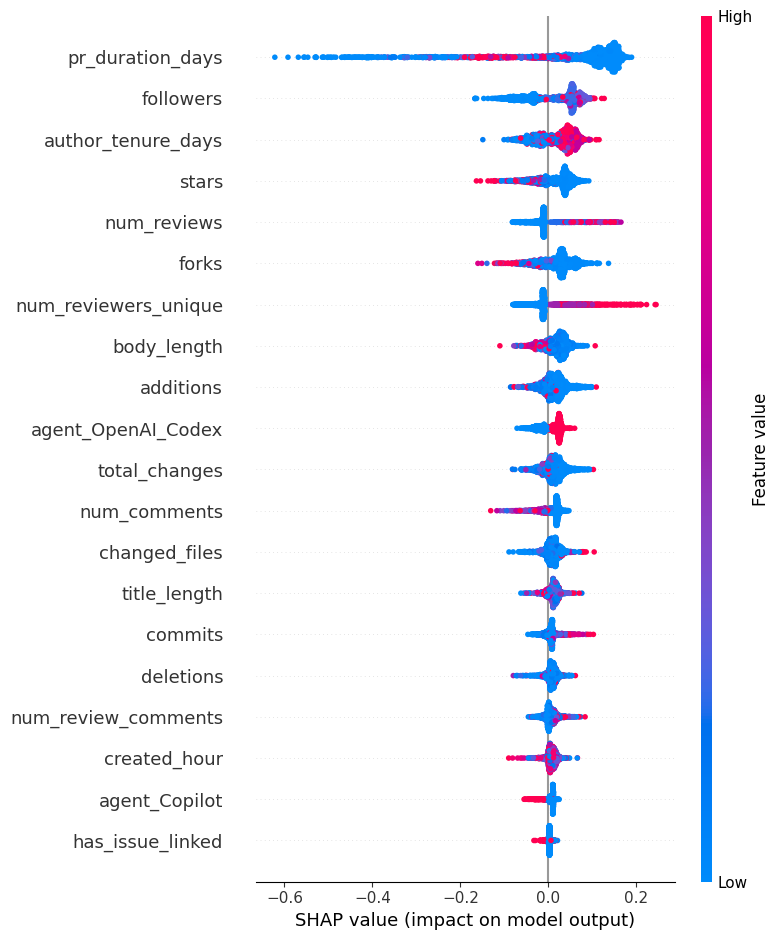

In [ ]:
# Interprétabilité du modèle RandomForest avec SHAP

import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

sample_size = min(2000, X_train.shape[0])
X_train_sample = X_train.sample(sample_size, random_state=42)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_sample)

print("type(shap_values) :", type(shap_values))

if isinstance(shap_values, list):
    shap_for_plot = shap_values[1]

elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    print("shap_values shape :", shap_values.shape)
    shap_for_plot = shap_values[:, :, 1]

else:
    shap_for_plot = shap_values

print("X_train_sample shape :", X_train_sample.shape)
print("shap_for_plot shape  :", shap_for_plot.shape)

# Visualisation globale des features
shap.summary_plot(
    shap_for_plot,
    X_train_sample,
    feature_names=X_train_sample.columns,
    show=True,
)


PR acceptée – contribution des features :


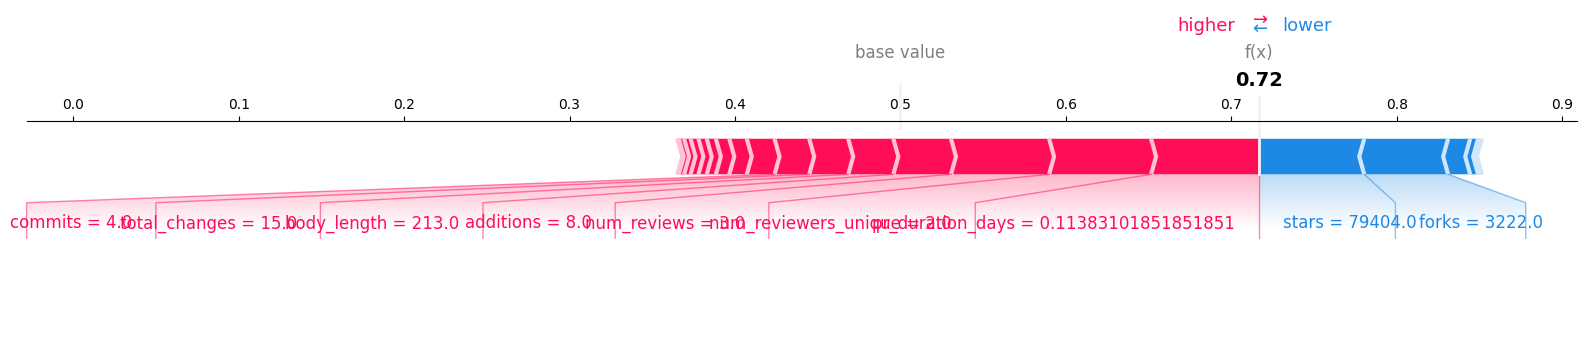

PR rejetée – contribution des features :


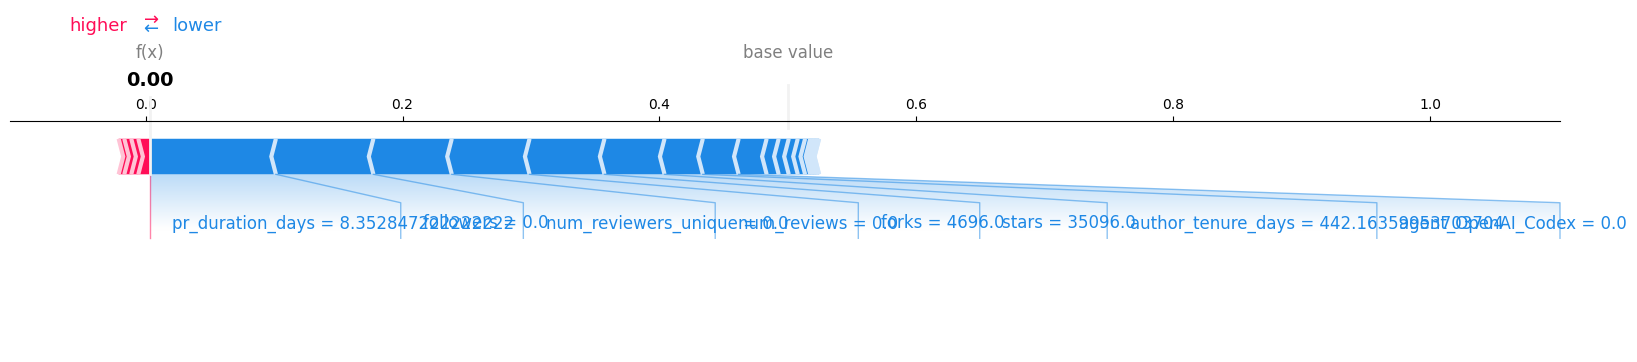

In [ ]:
import numpy as np
import shap

# choisir une PR acceptée et une rejetée
idx_accepted = y_test[y_test == 1].index[0]
idx_rejected = y_test[y_test == 0].index[0]

x_acc = X_test.loc[[idx_accepted]]
x_rej = X_test.loc[[idx_rejected]]

def get_shap_for_instance(explainer, x_row, class_index=1):
    """
    Retourne (shap_values_1D, expected_value) pour une seule instance x_row,
    en gérant les 3 formats possibles de sortie SHAP.
    """
    sv = explainer.shap_values(x_row)

    if isinstance(sv, list):
        shap_1d = sv[class_index][0]
        expected = explainer.expected_value[class_index]

    elif isinstance(sv, np.ndarray) and sv.ndim == 3:
        shap_1d = sv[0, :, class_index]
        expected = explainer.expected_value[class_index]

    else:
        shap_1d = sv[0]
        expected = explainer.expected_value

    return shap_1d, expected

# SHAP pour une PR acceptée et une rejetée
sv_acc, exp_acc = get_shap_for_instance(explainer, x_acc, class_index=1)
sv_rej, exp_rej = get_shap_for_instance(explainer, x_rej, class_index=1)

print("PR acceptée - contribution des features :")
shap.force_plot(exp_acc, sv_acc, x_acc, matplotlib=True)

print("PR rejetée - contribution des features :")
shap.force_plot(exp_rej, sv_rej, x_rej, matplotlib=True)


Colonnes agent : ['agent_Claude_Code', 'agent_Copilot', 'agent_Cursor', 'agent_Devin', 'agent_OpenAI_Codex']
shap_agents shape : (2000, 5)


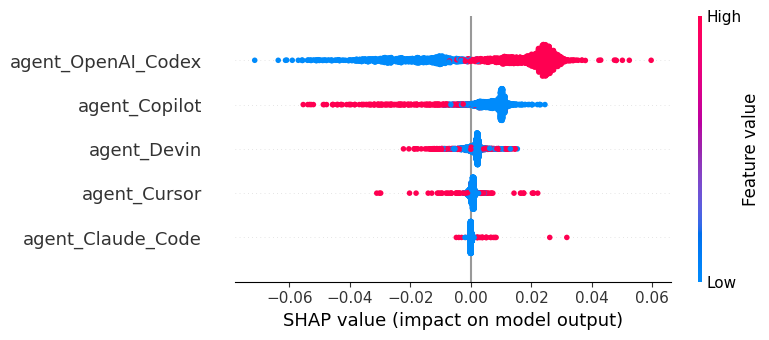

In [ ]:
# SHAP summary plot pour les agents uniquement

agent_cols = [c for c in X_train_sample.columns if c.startswith("agent_")]
print("Colonnes agent :", agent_cols)

agent_idx = [X_train_sample.columns.get_loc(c) for c in agent_cols]

shap_agents = shap_for_plot[:, agent_idx]

print("shap_agents shape :", shap_agents.shape)

shap.summary_plot(
    shap_agents,
    X_train_sample[agent_cols],
    feature_names=agent_cols,
    show=True,
)
